In [64]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import grad

import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [65]:
# import and login Weights and Baises
import wandb
!wandb login

wandb: Currently logged in as: adisiddharth (use `wandb login --relogin` to force relogin)


In [66]:
# Initialize wandb project
wandb.init(project = 'Captum Pytorch Cycle Phase')

wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-07-21 15:49:09.764128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-21 15:49:09.764161: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [67]:
#set cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [68]:
# Train dataset
train = pd.read_csv('Endometriosis_subset_train_feature_extract_no_mamc_splitfunction_random.csv')

# Set index to IDs
train.set_axis(train['meth_id'], inplace = True)

# Drop the ID cols 
cols_drop = ['meth_id', 'meth_id.1']
train.drop(columns=cols_drop, inplace = True)

# Change Endo Yes/No to binary
train['Endometriosis_int'] = np.where(train['Endometriosis'] == 'Yes', 1, train['Endometriosis'])
train['Endometriosis_int'] = np.where(train['Endometriosis_int'] == 'No', 0, train['Endometriosis_int'])

train.drop(train.loc[train['Stage'] == 'UNKNOWN'].index, inplace=True)

# Change Endo Yes/No to binary
train['Cycle_Phase_1'] = np.where(train['Cycle_Phase'] == 'PE', 0, '')
train['Cycle_Phase_2'] = np.where(train['Cycle_Phase'] == 'SE', 1, '')
train['Cycle_Phase_3'] = np.where(train['Cycle_Phase'] == 'Menstrual', 2, '')
train['Cycle_Phase_int'] = train['Cycle_Phase_1'] + train['Cycle_Phase_2'] + train['Cycle_Phase_3'] 

train.drop(train[train['Cycle_Phase_int'] == '2'].index, inplace = True)

# Comment out to remove Cycle Phase from features
y_train = train['Cycle_Phase_int']
x_train = train.iloc[:, 5:-5]

In [69]:
# Val dataset
val = pd.read_csv('Endometriosis_subset_val_feature_extract_no_mamc_splitfunction_random.csv')

#set index to IDs
val = val.set_axis(val['meth_id'])

# Group ESE, MSE and LSE into SE 
val.loc[val['Cycle_Phase'].isin(['ESE', 'MSE', 'LSE']), 'Cycle_Phase'] = 'SE'

# Change Endo Yes/No to binary
val['Endometriosis_int'] = np.where(val['Endometriosis'] == 'Yes', 1, val['Endometriosis'])
val['Endometriosis_int'] = np.where(val['Endometriosis_int'] == 'No', 0, val['Endometriosis_int'])

val.drop(val.loc[val['Stage'] == 'UNKNOWN'].index, inplace=True)

# Change Endo Yes/No to binary
val['Cycle_Phase_1'] = np.where(val['Cycle_Phase'] == 'PE', 0, '')
val['Cycle_Phase_2'] = np.where(val['Cycle_Phase'] == 'SE', 1, '')
val['Cycle_Phase_3'] = np.where(val['Cycle_Phase'] == 'Menstrual', 2, '')
val['Cycle_Phase_int'] = val['Cycle_Phase_1'] + val['Cycle_Phase_2'] + val['Cycle_Phase_3'] 

val.drop(val[val['Cycle_Phase_int'] == '2'].index, inplace = True)

# Comment out to remove Cycle Phase from features
y_val = val['Cycle_Phase_int']
x_val = val.iloc[:, 7:-5]

In [70]:
# Test dataset
test = pd.read_csv('Endometriosis_subset_test2_feature_extract_no_mamc_splitfunction_random.csv')

# Assign index as IDs
test.set_index('meth_id', inplace = True)

test.drop(test.loc[test['Stage'] == 'UNKNOWN'].index, inplace=True)

test.drop('Unnamed: 0', axis=1, inplace=True)

# Group ESE, MSE and LSE into SE 
test.loc[test['Cycle_Phase'].isin(['ESE', 'MSE', 'LSE']), 'Cycle_Phase'] = 'SE'

# Change Endo Yes/No to binary
test['Cycle_Phase_1'] = np.where(test['Cycle_Phase'] == 'PE', 0, '')
test['Cycle_Phase_2'] = np.where(test['Cycle_Phase'] == 'SE', 1, '')
test['Cycle_Phase_3'] = np.where(test['Cycle_Phase'] == 'Menstrual', 2, '')
test['Cycle_Phase_int'] = test['Cycle_Phase_1'] + test['Cycle_Phase_2'] + test['Cycle_Phase_3'] 

test.drop(test[test['Cycle_Phase_int'] == '2'].index, inplace = True)

# Change Endo Yes/No to binary
test['Endometriosis_int'] = np.where(test['Endometriosis'] == 'Yes', 1, test['Endometriosis'])
test['Endometriosis_int'] = np.where(test['Endometriosis_int'] == 'No', 0, test['Endometriosis_int'])

# Comment out to remove Cycle Phase from features
#test = test.join(pd.get_dummies(test['Cycle_Phase']))
y_test = test['Cycle_Phase_int']
x_test = test.iloc[:, 5:-5]

In [71]:
# Set train and test features and labels
train_features = x_train.to_numpy()
train_labels = y_train.to_numpy(dtype=np.int64)

val_features = x_val.to_numpy()
val_labels = y_val.to_numpy(dtype=np.int64)

test_features = x_test.to_numpy()
test_labels = y_test.to_numpy(dtype=np.int64)

In [72]:
from sklearn.preprocessing import StandardScaler
train_features = StandardScaler().fit_transform(train_features)
val_features = StandardScaler().fit_transform(val_features)
test_features = StandardScaler().fit_transform(test_features)

In [73]:
train_features.shape, val_features.shape, test_features.shape

((705, 45000), (175, 45000), (47, 45000))

In [74]:
# Set hyperparameters
lr=0.0001 
optimizer = "Adamax"
num_epochs = 500
loss = 'CrossEntropyLoss'
nodes = 300
activation1 = 'relu'
activation2 = 'softmax'

# Set up config (columns) to record in wandb
run_config = {'lr': lr, 'optimizer': optimizer, 'epochs': num_epochs, 'nodes': nodes, 'activation1': activation1, 'activation2': activation2, 'loss': loss}
wandb_run = wandb.init(project='Captum Pytorch Cycle Phase', config=run_config)

In [75]:
if activation1 == 'relu':    
    activation1 = nn.ReLU()
elif activation1 == 'elu':    
    activation1 = nn.ELU()
elif activation1 == 'selu':    
    activation1 = nn.SELU()
elif activation1 == 'sigmoid':    
    activation1 = nn.Sigmoid()
if activation2 == 'sigmoid':    
    activation2 = nn.Sigmoid()
elif activation2 == 'relu':    
    activation2 = nn.ReLU()
elif activation2 == 'softmax':    
    activation2 = nn.Softmax()

In [76]:
# Model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(train_features.shape[1], nodes)
        self.relu1 = activation1
        self.linear2 = nn.Linear(nodes, nodes)
        self.relu2 = activation1
        self.linear3 = nn.Linear(nodes, nodes)
        self.relu3 = activation1
        self.linear4 = nn.Linear(nodes, nodes)
        self.relu4 = activation1
        self.linear5 = nn.Linear(nodes, nodes)
        self.relu5 = activation1
        self.linear6 = nn.Linear(nodes, nodes)
        self.relu6 = activation1
        self.linear7 = nn.Linear(nodes, nodes)
        self.relu7 = activation1
        self.linear8 = nn.Linear(nodes, nodes)
        self.relu8 = activation1
        self.linear9 = nn.Linear(nodes, nodes)
        self.relu9 = activation1
        self.linear10 = nn.Linear(nodes, 2)
        self.relu10 = activation2
        
    def forward(self, x):
        out1 = self.linear1(x)
        out2 = self.relu1(out1)
        out3 = self.relu2(self.linear2(out2))
        out4 = self.relu3(self.linear3(out3))
        out5 = self.relu4(self.linear4(out4))
        out6 = self.relu5(self.linear5(out5))
        out7 = self.relu6(self.linear6(out6))
        out8 = self.relu7(self.linear7(out7))
        out9 = self.relu8(self.linear8(out8))
        out10 = self.relu9(self.linear9(out9))
        out11 = self.relu10(self.linear10(out10))
        return out11

    
model = Model()

import numpy as np
min_valid_loss = np.inf

input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)

val_input_tensor = torch.from_numpy(val_features).type(torch.FloatTensor)
val_label_tensor = torch.from_numpy(val_labels)
for e in range(num_epochs):
    train_loss = 0.0
    #model.train()     # Optional when not using Model Specific layer
    if loss == 'MAE':
        criterion = nn.L1Loss()
    elif loss == 'CrossEntropyLoss':    
        criterion = nn.CrossEntropyLoss()
    elif loss == 'MSE':    
        criterion = nn.MSELoss()
    elif loss == 'BCE':    
        criterion = nn.BCELoss()
    elif loss == 'BCEWithLogitsLoss':
        criterion = nn.BCEWithLogitsLoss
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer == 'Adamax':
        optimizer = torch.optim.Adamax(model.parameters(), lr=lr)
    elif optimizer == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    optimizer.zero_grad()
    target = model(input_tensor)
    loss = criterion(target, label_tensor)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer


    target = model(val_input_tensor)
    loss = criterion(target,val_label_tensor)
    valid_loss = loss.item() * val_input_tensor.size(0)
    if e % 50 == 0:
        print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(val_input_tensor)} \t\t Validation Loss: {valid_loss / len(val_input_tensor)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

#input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)

/tmp/ipykernel_6163/3942551225.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out11 = self.relu10(self.linear10(out10))


Epoch 1 		 Training Loss: 0.003961499759129116 		 Validation Loss: 0.6931700110435486
Validation Loss Decreased(inf--->121.304752) 	 Saving The Model
Validation Loss Decreased(121.304752--->121.295781) 	 Saving The Model
Validation Loss Decreased(121.295781--->121.285465) 	 Saving The Model
Validation Loss Decreased(121.285465--->121.273209) 	 Saving The Model
Validation Loss Decreased(121.273209--->121.258523) 	 Saving The Model
Validation Loss Decreased(121.258523--->121.240571) 	 Saving The Model
Validation Loss Decreased(121.240571--->121.218792) 	 Saving The Model
Validation Loss Decreased(121.218792--->121.192881) 	 Saving The Model
Validation Loss Decreased(121.192881--->121.163070) 	 Saving The Model
Validation Loss Decreased(121.163070--->121.128638) 	 Saving The Model
Validation Loss Decreased(121.128638--->121.088740) 	 Saving The Model
Validation Loss Decreased(121.088740--->121.042584) 	 Saving The Model
Validation Loss Decreased(121.042584--->120.989230) 	 Saving The Mode

In [77]:
out_probs_train = model(input_tensor).detach().numpy()
out_classes_train = np.argmax(out_probs_train, axis=1)
train_acc = sum(out_classes_train == train_labels) / len(train_labels)
print("Train Accuracy:", train_acc)

Train Accuracy: 1.0


/tmp/ipykernel_6163/3942551225.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out11 = self.relu10(self.linear10(out10))


In [78]:
val_input_tensor = torch.from_numpy(val_features).type(torch.FloatTensor)
out_probs_val = model(val_input_tensor).detach().numpy()
out_classes_val = np.argmax(out_probs_val, axis=1)
val_acc = sum(out_classes_val == val_labels) / len(val_labels)
print("Test Accuracy:", val_acc)

Test Accuracy: 0.8857142857142857


/tmp/ipykernel_6163/3942551225.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out11 = self.relu10(self.linear10(out10))


In [79]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs_test = model(test_input_tensor).detach().numpy()
out_classes_test = np.argmax(out_probs_test, axis=1)
test_acc = sum(out_classes_test == test_labels) / len(test_labels)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.8936170212765957


/tmp/ipykernel_6163/3942551225.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out11 = self.relu10(self.linear10(out10))


In [80]:
r_probs = [0 for _ in range(len(y_test))]

In [81]:
test_labels = test_labels.astype('float32')

In [82]:
from sklearn.metrics import roc_curve, roc_auc_score
#Random chance ROC
r_auc = roc_auc_score(test_labels, r_probs)
r_fpr, r_tpr, _ = roc_curve(test_labels, r_probs)

#Train ROC
tr_fpr, tr_tpr, _ = roc_curve(train_labels, out_probs_train[:, 1])
tr_auc = roc_auc_score(train_labels, out_probs_train[:, 1])

#Val ROC
val_fpr, val_tpr, _ = roc_curve(val_labels, out_probs_val[:, 1])
val_auc = roc_auc_score(val_labels, out_probs_val[:, 1])

#Test ROC
fpr, tpr, _ = roc_curve(test_labels, out_probs_test[:, 1])
auc = roc_auc_score(test_labels, out_probs_test[:, 1])

In [83]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Test Prediction: AUROC = %.3f' % (auc))
print('Train Prediction: AUROC = %.3f' % (tr_auc))
print('Val Prediction: AUROC = %.3f' % (val_auc))

Random (chance) Prediction: AUROC = 0.500
Test Prediction: AUROC = 0.886
Train Prediction: AUROC = 1.000
Val Prediction: AUROC = 0.957


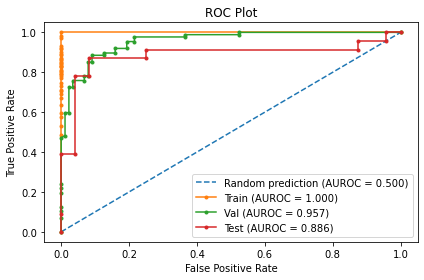

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.


In [84]:
# AUC Plots
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(tr_fpr, tr_tpr, marker='.', label='Train (AUROC = %0.3f)' % tr_auc)
plt.plot(val_fpr, val_tpr, marker='.', label='Val (AUROC = %0.3f)' % val_auc)
plt.plot(fpr, tpr, marker='.', label='Test (AUROC = %0.3f)' % auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend(loc = 'lower right', prop={'size': 10}) 
plt.tight_layout()
#plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'ROC_Curve' + kfold + '.png', bbox_inches = "tight")

In [30]:
# record more metrics in wandb
wandb_run.log({'auc': auc, 'train_accuracy': train_acc, 'test_accuracy': test_acc})

In [31]:
# set up integrated gradients 
ig = IntegratedGradients(model)

# obtain integrated gradient attributes
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

# get cpg islands
feature_names = x_train.columns

<ipython-input-21-51d084ecc3c6>:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out11 = self.relu10(self.linear10(out10))


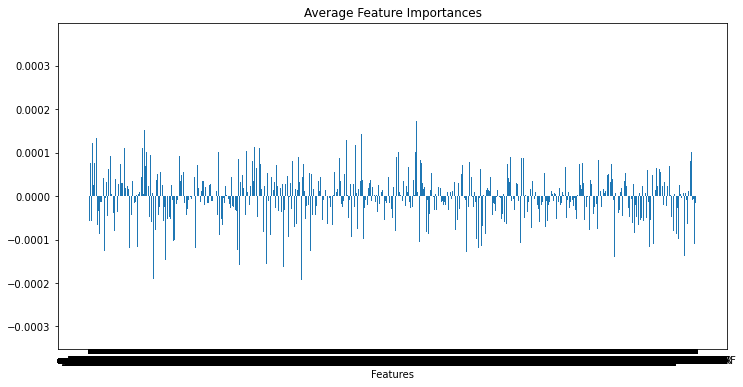

In [32]:
# Plot relative importance of cpg islands
attributes = pd.DataFrame()
cpg = []
imp = []
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    #print(title)
    for i in range(len(feature_names)):
        #print(feature_names[i], ": ", '%.3f'%(importances[i]))
        cpg.append(feature_names[i])
        imp.append(importances[i])
    
    
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
attributes['CPG'] = cpg
attributes['Attributes'] = imp
visualize_importances(feature_names, np.mean(attr, axis=0))

In [33]:
# collate data into dataframe
attributes['CPG'] = cpg
attributes['Attributes'] = imp
attributes['Attributes Abs'] = np.abs(attributes['Attributes']) # Absolute value of attributes

# Order df by descending absolute value of attributes
attributes = attributes.sort_values(by = ['Attributes Abs'], ascending = False)

at = attributes.reset_index()

Text(0.5, 1.0, 'Integrated Gradients Attributes')

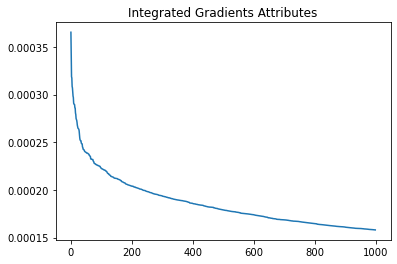

In [34]:
plt.plot(np.abs(at['Attributes Abs'][:1000]))
plt.title('Integrated Gradients Attributes')

In [35]:
# Get top 500 CPG islands
cpg_captum = attributes.iloc[:500,0].to_list()

In [36]:
# subset testing set CPG islands using top 500 CPG islands from IG 
top_500_cpg_df = x_test[x_test.columns.intersection(cpg_captum)]

In [37]:
# set up color map
color_list = ['r', 'b', 'g', 'y', 'k', 'm']
vals_1 = y_test.unique()
lut_1 = dict(zip(vals_1, ''.join(color_list[:len(vals_1)])))
row_colors_1 = y_test.map(lut_1).values

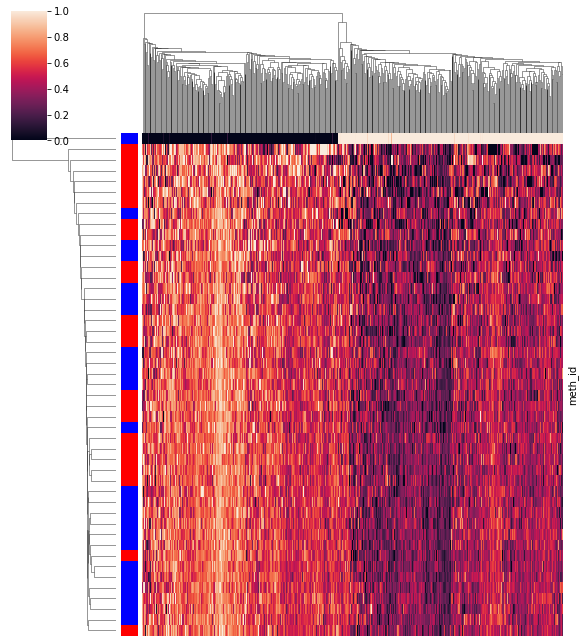

In [39]:
import seaborn as sns
g = sns.clustermap(top_500_cpg_df, standard_scale=1, row_colors=row_colors_1)
g.ax_heatmap.tick_params(right=False, bottom=False, labelbottom=False, labelright=False)
#g.fig.suptitle("Pytorch Grouping extremes train, extreme visualize clustermap")